In [1]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "cm"

import src.kgof.density as density
import src.kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker

In [2]:
n = 1000
dim = 1

mean1 = tf.constant([[0.]])
mean2 = tf.constant([[8.]])
noise_mean = tf.constant([[6.]])

2023-01-23 16:34:36.631765: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-23 16:34:36.631801: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2023-01-23 16:34:36.631808: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2023-01-23 16:34:36.631889: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2023-01-23 16:34:36.631910: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2023-01-23 16:34:36.631915: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2023-01-23 16:34:36.632576: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

# Gaussian Mixture

In [4]:
tf.random.set_seed(1)

In [5]:
## mixure of gaussians
k = 1
delta = 8.
ratio_sample = 1.
ratio_target = 0.5

target, log_prob_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_target)
proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_sample)

In [6]:
n = 1000
samples_on = target.sample(n)
samples_on_df = pd.DataFrame({f"x{i}": samples_on[:, i] for i in range(dim)})
samples_on_df["type"] = "on"

samples_off = proposal_off.sample(n)
samples_off_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
samples_off_df["type"] = "off"

samples_df = pd.concat([samples_on_df, samples_off_df], ignore_index=True)

In [8]:
ntrain = n // 2
threshold = 1.

samples_init = samples_off
# samples_init = samples_on

sample_off_train, sample_off_test = samples_init[:ntrain, ], samples_init[ntrain:, ]

# start_pts = sample_off_train
start_pts = tf.concat([
    sample_off_train[:(ntrain//2)], 
    tf.random.uniform(shape=(ntrain//2, dim), minval=-10., maxval=10.)], axis=0)

mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold, max_iterations=200)

In [9]:
mode_list, inv_hess_list

([<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
  <tf.Tensor: shape=(1,), dtype=float32, numpy=array([8.], dtype=float32)>],
 [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>])

In [10]:
proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)

In [11]:
_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

In [12]:
std = [.9, 1.286, 1.29, 1.1520001]

In [13]:
T = 10

mh = MCMCKernel(log_prob=log_prob_fn)
mh.run(steps=T, std=std, x_init=sample_off_train, ind_pair_list=ind_pair_list, **proposal_dict)

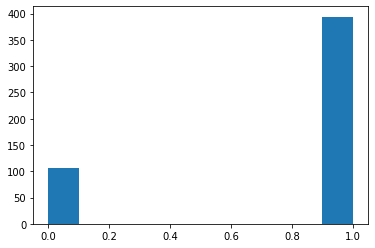

In [14]:
if len(mh.if_accept.shape) == 3:
    xx = (np.sum(mh.if_accept.numpy()[-1], axis=0) > 0.).astype(np.float32)
else:
    xx = (np.sum(mh.if_accept.numpy(), axis=0) > 0.).astype(np.float32)
_ = plt.hist(xx)

In [18]:
if len(mh.x.shape) == 4:
    x_all = mh.x[-1]
else:
    x_all = mh.x
    
x_0 = x_all[0].numpy()
x_t = x_all[-1].numpy()

x0_df = pd.DataFrame({f"x{i}": x_0[:, i] for i in range(dim)})
x0_df["type"] = "Before"

xt_df = pd.DataFrame({f"x{i}": x_t[:, i] for i in range(dim)})
xt_df["type"] = "After"

sample_on_df = pd.DataFrame({f"x{i}": samples_on.numpy()[:x_0.shape[0], i] for i in range(dim)})
sample_on_df["type"] = "Target"

x0_df = pd.concat([x0_df, sample_on_df], ignore_index=True)
xt_df = pd.concat([xt_df, sample_on_df], ignore_index=True)


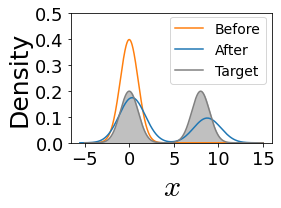

In [115]:
# only works for dim=1
xx = tf.reshape(tf.linspace(-5., 15., 1000), (-1, 1))

yy_sample = tf.exp(log_prob_off_fn(xx)) / tf.math.sqrt(2 * np.pi)
sample_df = pd.DataFrame({"x": xx[:, 0].numpy(), "prob": yy_sample.numpy(), "type": "Before"})

yy_sample_on = tf.exp(log_prob_fn(xx)) / tf.math.sqrt(2 * np.pi)
sample_on_df = pd.DataFrame({"x": xx[:, 0].numpy(), "prob": yy_sample_on.numpy(), "type": "Before"})

res_df = pd.concat([x0_df, xt_df, sample_on_df], ignore_index=True)

fig = plt.figure(figsize=(4, 3)) # (7, 3)
sns.lineplot(data=sample_df, x="x", y="prob",
            color="tab:orange",
            label="Before",
            )
sns.kdeplot(data=res_df.loc[res_df.type.isin(["After"])], x="x0", 
            color="tab:blue",
            label="After"
            )
sns.lineplot(data=sample_on_df, x="x", y="prob",
             color="grey",
             label="Target",
            )
plt.fill_between(sample_on_df.x, sample_on_df.prob, color="silver")

plt.xlabel("$x$", fontsize=30)
plt.ylabel("Density", fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.legend(fontsize=18)
plt.ylim(top=0.5)
plt.legend(
    fontsize=14, loc="upper center", bbox_to_anchor=(0.73, 1.03), #columnspacing=0.8, handletextpad=0.8,
)
plt.tight_layout()
fig.savefig("figs/bimodal_density_plot.pdf")